In [1]:
### ----- Imports ----- ###

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import os.path
import os
import shutil
import glob
import h5py
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import backend as K
from scipy import stats

dataset = 'v1b'

2023-09-27 13:45:54.988934: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-09-27 13:45:54.988961: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [38]:
### ----- Parameters ----- ###

# Where to save the products
models_figs_path = '/home/sdybing/mlaapde/testdata_preds/all_test_rerun/revised_figures/'

# MLAAPDE/data generation params
sr = 20 # Sampling rate
trim_sec = 60 # Trimming amount around phase pick to get from MLAAPDE
trim_pre_sec = trim_sec
trim_post_sec = trim_pre_sec
window_len = trim_pre_sec + trim_post_sec
n_channels = 3 # Instrument channels
cut_lens = [7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 25, 30, 35, 40, 50, 60, 70, 80, 90, 100, 110, 120]
cut_lens_finish = [70, 80, 90, 100, 110, 120]
cut_lens_test = [120]
desired_shift = 3
max_shift = desired_shift * 2 # Since the shifting method actually makes it half what this value is set to
min_snr_db = False
max_snr_db = False
log_progress_fraction = 100
valid_phases = ['P', 'Pn', 'Pg']
cast_dtype = np.float32

# Training/model params
epochs_number = 200
batch_size = int(256) # Reducing to help memory
monte_carlo_sampling = 50
drop_rate = 0.5
filters = [32, 64, 96, 128, 256] 

# Used if loading a trained model
training_dataset = 'v1b'
shift_status = 'shifted'
model_folder_path = '/home/sdybing/mlaapde/training/'

# To make end error plots
mean_errors = []
median_errors = []
std_errors = []

per50_errors = []
per60_errors = []
per70_errors = []
per80_errors = []
per90_errors = []
per95_errors = []

per50_medians_errors = []
per60_medians_errors = []
per70_medians_errors = []
per80_medians_errors = []
per90_medians_errors = []
per95_medians_errors = []

In [3]:
### ----- Load the MLAAPDE testing dataset from HDF5 files ----- ###

hdf5_save_dir = '/hdd/mlaapde/decimated'

testing_data = h5py.File(hdf5_save_dir + '/testing_data.hdf5', 'r')
# test_waves = testing_data['waves'][:]
test_mags = testing_data['magnitude'][:]
test_phase_id = testing_data['phase_id'][:]

testing_data.close()

In [4]:
new_test_pids = []

for idx in range(len(test_phase_id)):
#     print(test_phase_id[idx])
#     print(test_phase_id[idx].decode())
    new_test_pids.append(test_phase_id[idx].decode())

In [5]:
print(new_test_pids[0].split('_')[0])

mlaa_eventids = []

for idx in range(len(np.array(new_test_pids))):
    eventid = new_test_pids[idx].split('_')[0]
    mlaa_eventids.append(eventid)

us70006xvh


In [6]:
unique_mlaa_eventids = list(set(mlaa_eventids))

In [7]:
len(unique_mlaa_eventids)

26987

In [8]:
# train_data = h5py.File(hdf5_save_dir + '/training_data_full_decimate2.hdf5', 'r')
# train_mags = train_data['magnitude'][:]

In [9]:
# test_waves_t = test_waves.transpose(0,2,1)

# print(test_waves_t.shape)
print(test_mags.shape)

(324365,)


In [10]:
# del test_waves

In [11]:
nsamp = 2920609
n_test_samp = len(test_mags)
data = 'testing'

In [12]:
### ----- Load the historic testing dataset ----- ###

historic_path = '/hdd/mlaapde/decimated/'

# historic_test_waves = np.load(historic_path + 'historic_test_waves.npy')
historic_test_mags = np.load(historic_path + 'historic_test_mags.npy')
historic_test_eventids = np.load(historic_path + 'historic_test_eventids.npy')
# print(historic_test_waves.shape)
n_channels_hist = 3

bad_hist_indices = np.loadtxt('/home/sdybing/mlaapde/codes/bad_historic_waves.txt').astype(int)

# historic_test_waves_nonan = np.delete(historic_test_waves, bad_hist_indices, axis = 0)
historic_test_mags_nonan = np.delete(historic_test_mags, bad_hist_indices, axis = 0)
historic_test_eventids_nonan = np.delete(historic_test_eventids, bad_hist_indices, axis = 0)

# print(historic_test_waves.shape)
# print(historic_test_waves_nonan.shape)
print(historic_test_mags.shape)
print(historic_test_mags_nonan.shape)
print(historic_test_eventids_nonan.shape)

# n_historic_test_samp = len(historic_test_waves_nonan)
n_historic_test_samp = len(historic_test_mags_nonan)


(13449,)
(13151,)
(13151,)


In [13]:
unique_historic_eventids = list(set(historic_test_eventids_nonan))
print(len(unique_historic_eventids))

76


In [14]:
all_eventids = np.concatenate((mlaa_eventids, historic_test_eventids_nonan))
all_unique_eventids = np.concatenate((unique_mlaa_eventids, unique_historic_eventids))

In [15]:
medians_errors = np.load('/home/sdybing/mlaapde/testdata_preds/all_test_rerun/catmag_abserror_window_forwill.npy')

In [17]:
### ----- FIGURE 3 ----- ###

### THE LOOP ###

# Just using MLAAPDE or historic too?
mlaa_only = False
counter = 0

for cut_len in cut_lens:
    
    median_error_idx = counter
    counter += 1
    
    shift_len = cut_len - max_shift
    print('---------------------------------')
    print('Cut len: ' + str(cut_len))
    print('Shift len: ' + str(shift_len))

    all_test_mags = np.concatenate((test_mags, historic_test_mags_nonan))
    # print(all_test_mags.shape)

    all_test_mags = np.round_(all_test_mags, decimals = 1) # Get rid of extra digits
    
    ### ----- Load the predicted magnitudes ----- ###
    
#     print('Loading saved predicted magnitudes...')
    
    if mlaa_only == False:
        tag = '_all_test'
        predict_all = np.load('/home/sdybing/mlaapde/testdata_preds/all_test_rerun/mag_preds/' + str(cut_len-6) + 's_window_magpreds.npy')
        
    if mlaa_only == True:
        tag = '_mlaa_only'
        predict_all = np.load('/home/sdybing/mlaapde/testdata_preds/mlaa_only/pred_mags_' + str(cut_len-6) + 's_window.npy')
    
    ## ----- Quick plot of the predictions vs. true magnitudes ----- ###

#     fig4, ax = plt.subplots(facecolor = 'white')
#     ax.scatter(all_test_mags, predict_all, alpha = 0.4, facecolors = 'r', edgecolors = 'r')
#     ax.plot([all_test_mags.min(), all_test_mags.max()], [all_test_mags.min(), all_test_mags.max()], 'k--', alpha=1, lw=2)
#     ax.set_xlabel('Measured magnitude')
#     ax.set_ylabel('Predicted magnitude')
#     plt.show()
# #     fig4.savefig(models_figs_path + 'scatter_plots/' + str(cut_len-6) + 's_window_scatter_pred_vs_cat.png')
#     plt.close();
    
    ### ----- Rename things ----- ###

    measured_mags = all_test_mags
    predicted_mags = predict_all.flatten()

    ### ----- Calculate the error and standard deviation ----- ###

    errors = []

    for idx in range(len(predicted_mags)):
        predicted = predicted_mags[idx]
        measured = measured_mags[idx]
        error = predicted - measured
        errors.append(error)
        
    mean_error = np.mean(np.array(errors))
    median_error = np.median(np.array(errors))
    std_error = np.std(np.array(errors))
    
    per50_error = np.percentile(errors, 50)
    per60_error = np.percentile(errors, 60)
    per70_error = np.percentile(errors, 70)
    per80_error = np.percentile(errors, 80)
    per90_error = np.percentile(errors, 90)
    per95_error = np.percentile(errors, 95)
    
    per50_errors.append(per50_error)
    per60_errors.append(per60_error)
    per70_errors.append(per70_error)
    per80_errors.append(per80_error)
    per90_errors.append(per90_error)
    per95_errors.append(per95_error)
    
    # print('Error shape: ' + str(np.array(errors).shape))

    print('95th percentile of all prediction errors: ' + str(round(per95_error,3)))
    print('50th percentile of all prediction errors: ' + str(round(per50_error,3)))
#     print('Mean error: ' + str(round(mean_error,3)))
    print('Median error: ' + str(round(median_error,3)))
#     print('Error standard deviation: ' + str(round(std_error,2)))

    mean_errors.append(mean_error)
    median_errors.append(median_error)
    std_errors.append(std_error)
    
    medians_errors_thistime = medians_errors[median_error_idx, :, 1]
    
    mederr_nonan = []
    for idx in range(len(medians_errors_thistime)):
        if np.isnan(medians_errors_thistime[idx]):
            pass
        else:
            mederr = medians_errors_thistime[idx]
            mederr_nonan.append(mederr)
    
    per50_medians_error = np.percentile(mederr_nonan, 50)
    per60_medians_error = np.percentile(mederr_nonan, 60)
    per70_medians_error = np.percentile(mederr_nonan, 70)
    per80_medians_error = np.percentile(mederr_nonan, 80)
    per90_medians_error = np.percentile(mederr_nonan, 90)
    per95_medians_error = np.percentile(mederr_nonan, 95)
    print('95th percentile of prediction median errors: ' + str(round(per95_medians_error,3)))
    
    per50_medians_errors.append(per50_medians_error)
    per60_medians_errors.append(per60_medians_error)
    per70_medians_errors.append(per70_medians_error)
    per80_medians_errors.append(per80_medians_error)
    per90_medians_errors.append(per90_medians_error)
    per95_medians_errors.append(per95_medians_error)

---------------------------------
Cut len: 7
Shift len: 1
95th percentile of all prediction errors: 1.851
50th percentile of all prediction errors: -0.005
Median error: -0.005
95th percentile of prediction median errors: 3.916
---------------------------------
Cut len: 8
Shift len: 2
95th percentile of all prediction errors: 1.797
50th percentile of all prediction errors: -0.011
Median error: -0.011
95th percentile of prediction median errors: 3.812
---------------------------------
Cut len: 9
Shift len: 3
95th percentile of all prediction errors: 1.757
50th percentile of all prediction errors: -0.038
Median error: -0.038
95th percentile of prediction median errors: 3.714
---------------------------------
Cut len: 10
Shift len: 4
95th percentile of all prediction errors: 1.732
50th percentile of all prediction errors: 0.017
Median error: 0.017
95th percentile of prediction median errors: 3.582
---------------------------------
Cut len: 11
Shift len: 5
95th percentile of all prediction 

In [24]:
# Plots the percentiles of the errors of the medians of the estimation bins across each time window. Basically summary of bin median errors

times = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 19, 24, 29, 34, 44, 54, 64, 74, 84, 94, 104, 114]
plt.plot(times, per50_medians_errors, label = '50th percentile (median)')
plt.plot(times, per60_medians_errors, label = '60th percentile')
plt.plot(times, per70_medians_errors, label = '70th percentile')
plt.plot(times, per80_medians_errors, label = '80th percentile')
plt.plot(times, per90_medians_errors, label = '90th percentile')
plt.plot(times, per95_medians_errors, label = '95th percentile')
plt.xlabel('Time window (s)')
plt.ylabel('Absolute error of estimated magnitude bin medians')
plt.xlim(1,114)
plt.ylim(0,4.5)
plt.legend()

# plt.show()
plt.savefig('/home/sdybing/mlaapde/testdata_preds/all_test_rerun/revised_figures/percentiles_allerrors.png', format = 'PNG', facecolor = 'white', transparent = False)
plt.close();


In [25]:
# Plots the percentiles of the errors of all of the estimations across each time window. Basically summary of all errors

times = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 19, 24, 29, 34, 44, 54, 64, 74, 84, 94, 104, 114]
plt.plot(times, np.abs(per50_errors), label = '50th percentile (median)')
plt.plot(times, np.abs(per60_errors), label = '60th percentile')
plt.plot(times, np.abs(per70_errors), label = '70th percentile')
plt.plot(times, np.abs(per80_errors), label = '80th percentile')
plt.plot(times, np.abs(per90_errors), label = '90th percentile')
plt.plot(times, np.abs(per95_errors), label = '95th percentile')
plt.xlabel('Time window (s)')
plt.ylabel('Absolute error of all estimated magnitudes')
plt.xlim(1,114)
plt.ylim(0,2.25)
plt.legend()


# plt.show()
plt.savefig('/home/sdybing/mlaapde/testdata_preds/all_test_rerun/revised_figures/percentiles_medianserrors.png', format = 'PNG', facecolor = 'white', transparent = False)
plt.close();

In [26]:
# Now trying to do one where it's the percentiles of errors across each bin, 
# so plotting percentiles by magnitude for each window instead of summary plot

---------------------------------
Cut len: 7
Shift len: 1
Calculating and saving bin stats...


/home/sdybing/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/sdybing/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)


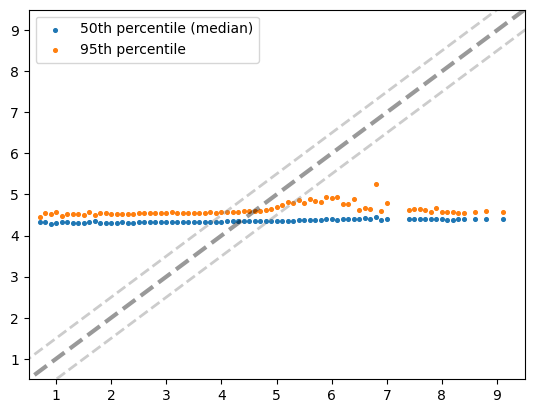

---------------------------------
Cut len: 8
Shift len: 2
Calculating and saving bin stats...


/home/sdybing/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/sdybing/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)


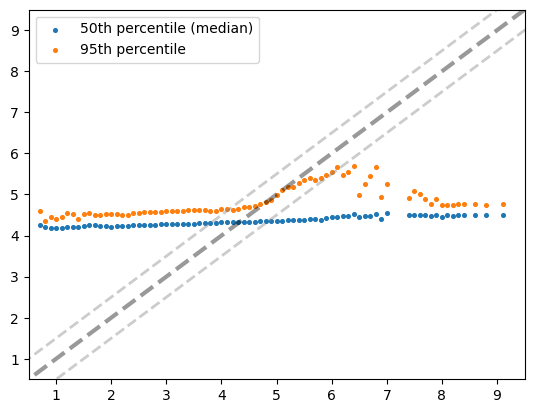

---------------------------------
Cut len: 9
Shift len: 3
Calculating and saving bin stats...


/home/sdybing/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/sdybing/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)


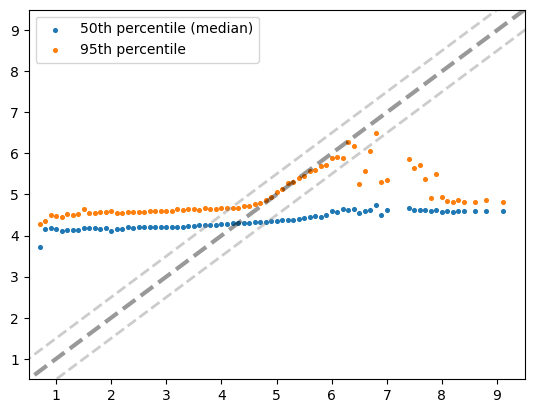

---------------------------------
Cut len: 10
Shift len: 4
Calculating and saving bin stats...


/home/sdybing/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/sdybing/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)


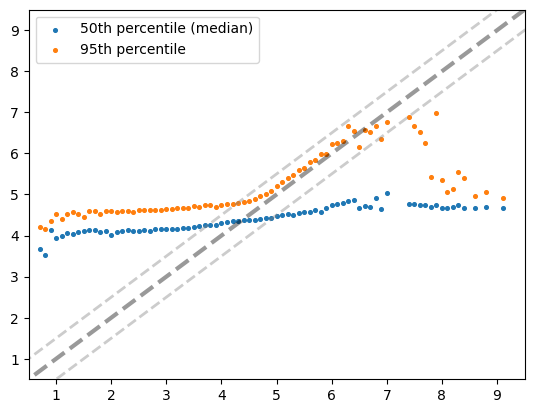

---------------------------------
Cut len: 11
Shift len: 5
Calculating and saving bin stats...


/home/sdybing/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/sdybing/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)


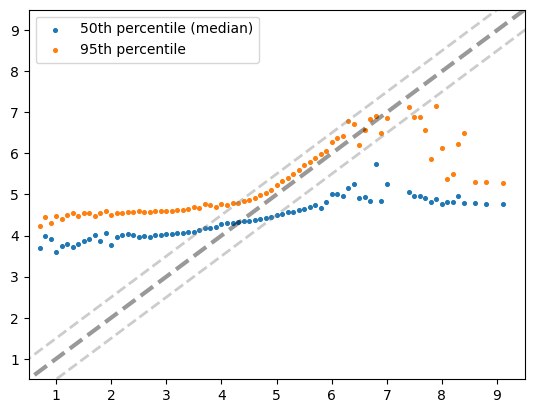

---------------------------------
Cut len: 12
Shift len: 6
Calculating and saving bin stats...


/home/sdybing/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/sdybing/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)


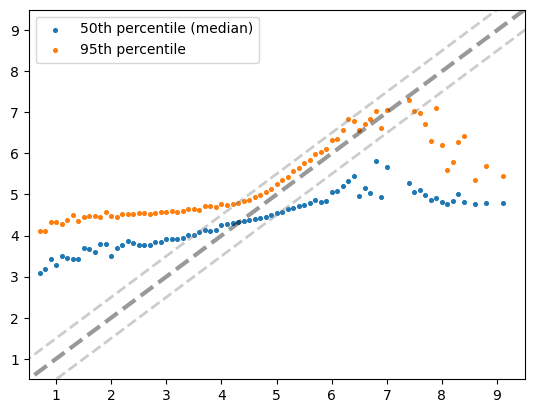

---------------------------------
Cut len: 13
Shift len: 7
Calculating and saving bin stats...


/home/sdybing/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/sdybing/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)


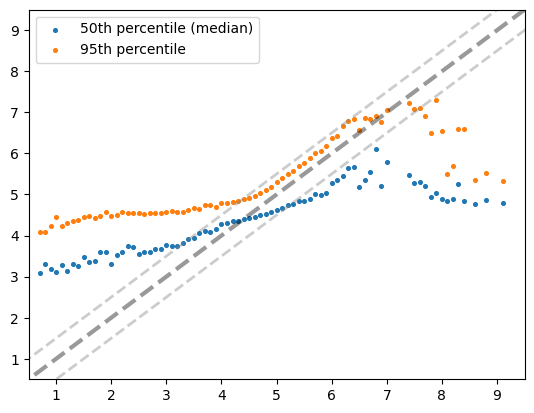

---------------------------------
Cut len: 14
Shift len: 8
Calculating and saving bin stats...


/home/sdybing/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/sdybing/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)


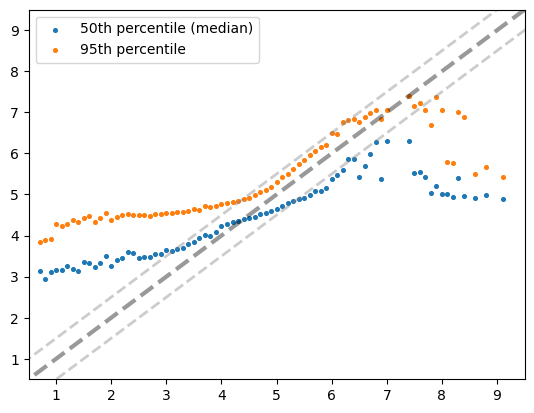

---------------------------------
Cut len: 15
Shift len: 9
Calculating and saving bin stats...


/home/sdybing/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/sdybing/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)


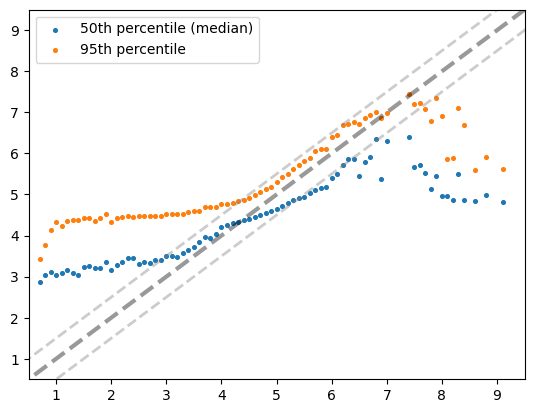

---------------------------------
Cut len: 16
Shift len: 10
Calculating and saving bin stats...


/home/sdybing/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/sdybing/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)


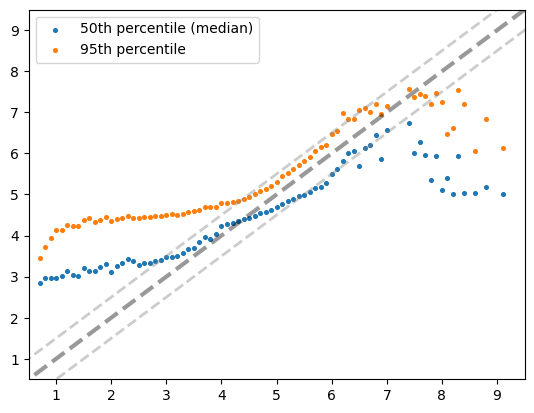

---------------------------------
Cut len: 17
Shift len: 11
Calculating and saving bin stats...


/home/sdybing/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/sdybing/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)


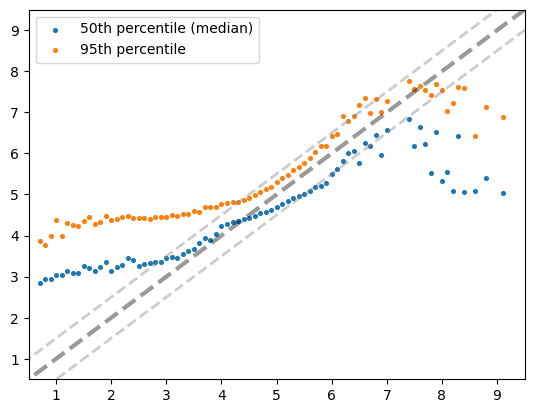

---------------------------------
Cut len: 18
Shift len: 12
Calculating and saving bin stats...


/home/sdybing/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/sdybing/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)


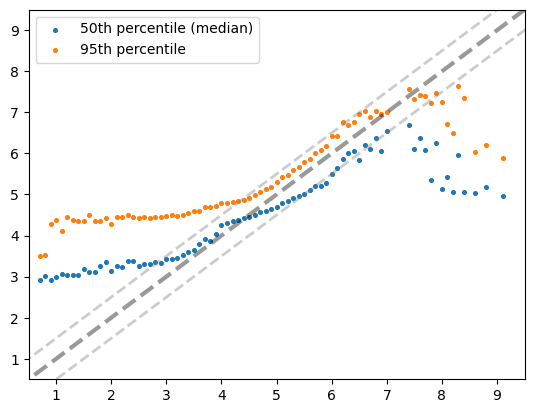

---------------------------------
Cut len: 19
Shift len: 13
Calculating and saving bin stats...


/home/sdybing/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/sdybing/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)


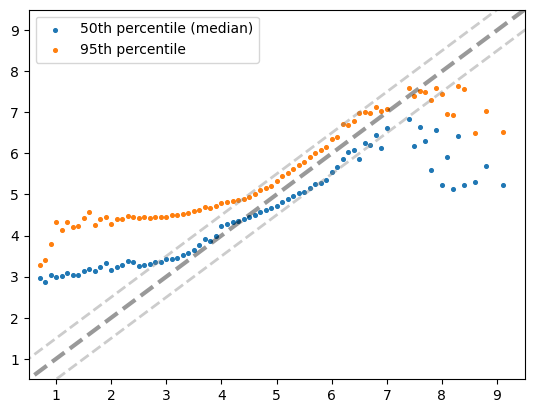

---------------------------------
Cut len: 20
Shift len: 14
Calculating and saving bin stats...


/home/sdybing/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/sdybing/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)


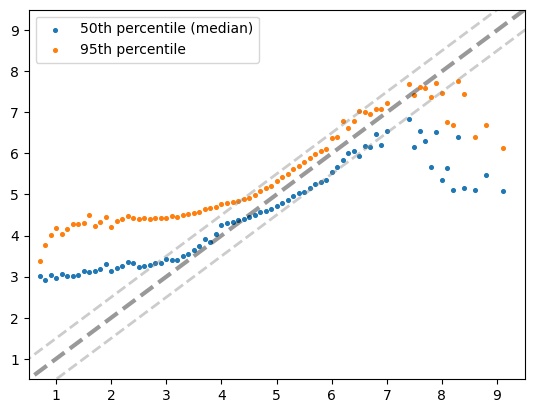

---------------------------------
Cut len: 25
Shift len: 19
Calculating and saving bin stats...


/home/sdybing/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/sdybing/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)


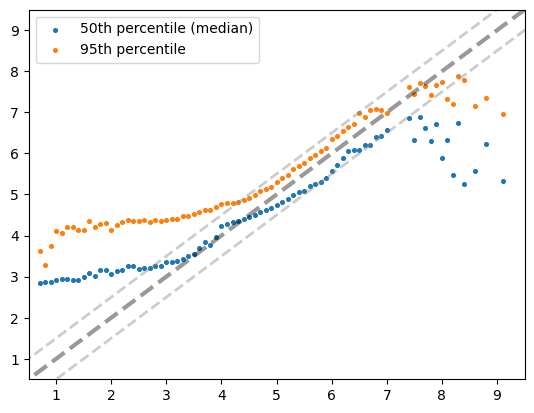

---------------------------------
Cut len: 30
Shift len: 24
Calculating and saving bin stats...


/home/sdybing/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/sdybing/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)


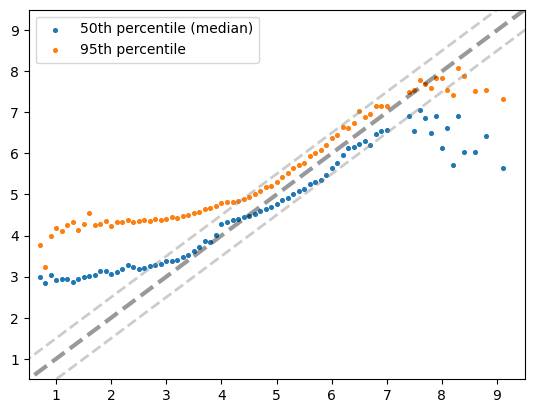

---------------------------------
Cut len: 35
Shift len: 29
Calculating and saving bin stats...


/home/sdybing/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/sdybing/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)


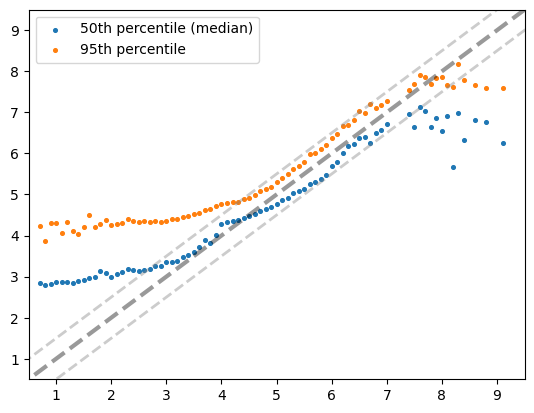

---------------------------------
Cut len: 40
Shift len: 34
Calculating and saving bin stats...


/home/sdybing/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/sdybing/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)


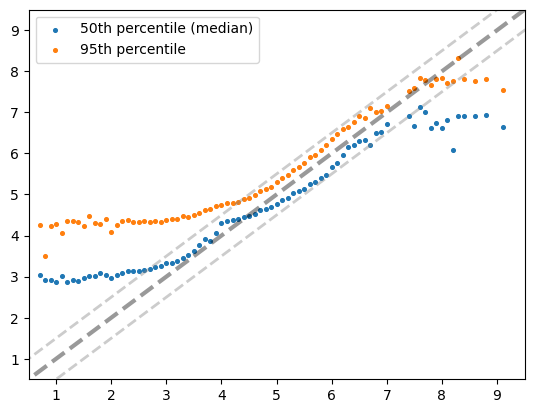

---------------------------------
Cut len: 50
Shift len: 44
Calculating and saving bin stats...


/home/sdybing/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/sdybing/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)


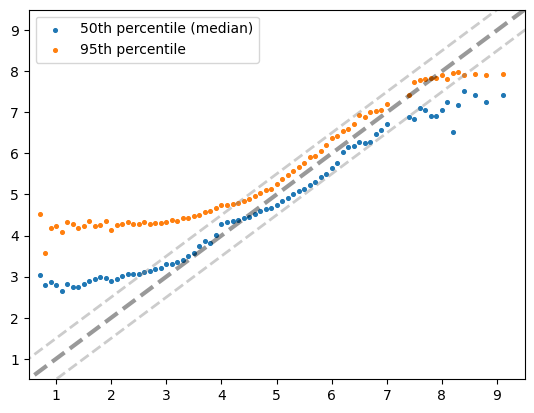

---------------------------------
Cut len: 60
Shift len: 54
Calculating and saving bin stats...


/home/sdybing/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/sdybing/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)


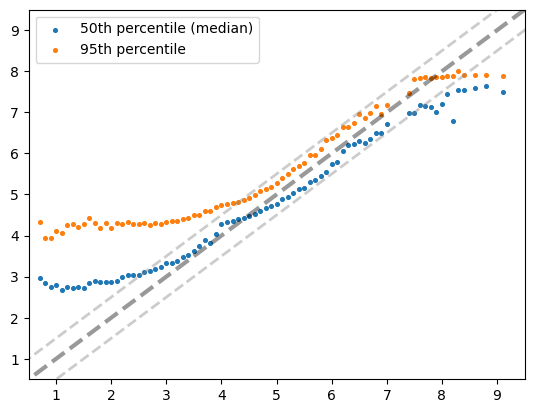

---------------------------------
Cut len: 70
Shift len: 64
Calculating and saving bin stats...


/home/sdybing/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/sdybing/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)


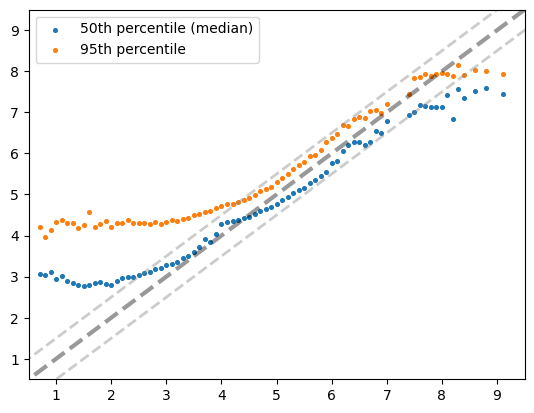

---------------------------------
Cut len: 80
Shift len: 74
Calculating and saving bin stats...


/home/sdybing/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/sdybing/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)


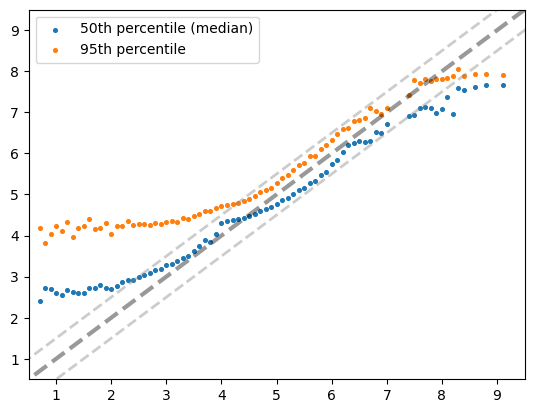

---------------------------------
Cut len: 90
Shift len: 84
Calculating and saving bin stats...


/home/sdybing/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/sdybing/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)


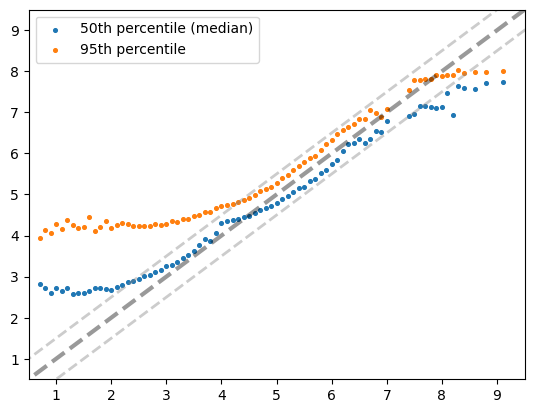

---------------------------------
Cut len: 100
Shift len: 94
Calculating and saving bin stats...


/home/sdybing/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/sdybing/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)


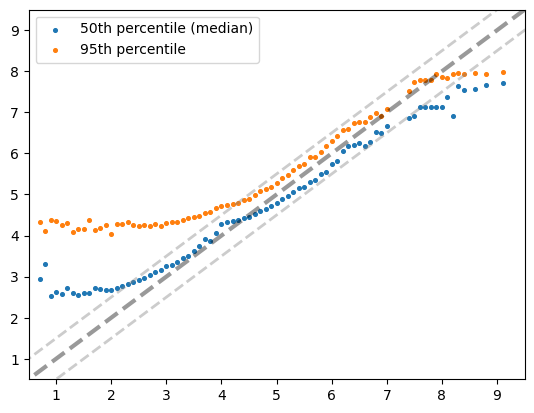

---------------------------------
Cut len: 110
Shift len: 104
Calculating and saving bin stats...


/home/sdybing/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/sdybing/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)


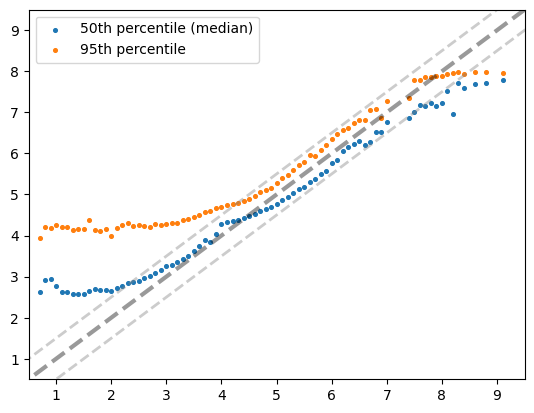

---------------------------------
Cut len: 120
Shift len: 114
Calculating and saving bin stats...


/home/sdybing/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/sdybing/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)


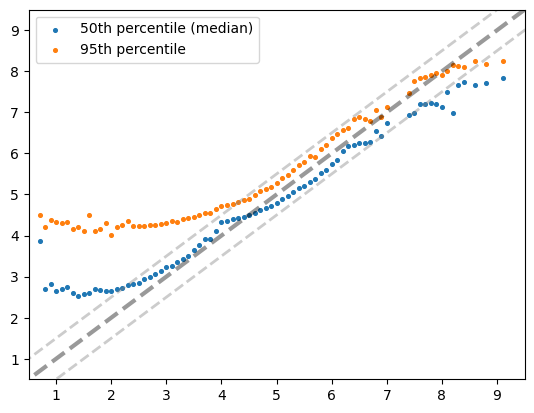

In [108]:
### ----- FIGURE 3 ----- ###

### THE LOOP ###

# Just using MLAAPDE or historic too?
mlaa_only = False
counter = 0

for cut_len in cut_lens:
    
    median_error_idx = counter
    counter += 1
    
    shift_len = cut_len - max_shift
    print('---------------------------------')
    print('Cut len: ' + str(cut_len))
    print('Shift len: ' + str(shift_len))

    all_test_mags = np.concatenate((test_mags, historic_test_mags_nonan))
    # print(all_test_mags.shape)

    all_test_mags = np.round_(all_test_mags, decimals = 1) # Get rid of extra digits
    
    ### ----- Load the predicted magnitudes ----- ###
    
#     print('Loading saved predicted magnitudes...')
    
    if mlaa_only == False:
        tag = '_all_test'
        predict_all = np.load('/home/sdybing/mlaapde/testdata_preds/all_test_rerun/mag_preds/' + str(cut_len-6) + 's_window_magpreds.npy')
        
    if mlaa_only == True:
        tag = '_mlaa_only'
        predict_all = np.load('/home/sdybing/mlaapde/testdata_preds/mlaa_only/pred_mags_' + str(cut_len-6) + 's_window.npy')
    
    ## ----- Quick plot of the predictions vs. true magnitudes ----- ###

#     fig4, ax = plt.subplots(facecolor = 'white')
#     ax.scatter(all_test_mags, predict_all, alpha = 0.4, facecolors = 'r', edgecolors = 'r')
#     ax.plot([all_test_mags.min(), all_test_mags.max()], [all_test_mags.min(), all_test_mags.max()], 'k--', alpha=1, lw=2)
#     ax.set_xlabel('Measured magnitude')
#     ax.set_ylabel('Predicted magnitude')
#     plt.show()
# #     fig4.savefig(models_figs_path + 'scatter_plots/' + str(cut_len-6) + 's_window_scatter_pred_vs_cat.png')
#     plt.close();
    
    ### ----- Rename things ----- ###

    measured_mags = all_test_mags
    predicted_mags = predict_all.flatten()

    ### ----- Calculate the error and standard deviation ----- ###

    errors = []

    for idx in range(len(predicted_mags)):
        predicted = predicted_mags[idx]
        measured = measured_mags[idx]
        error = predicted - measured
        errors.append(error)
        
    mean_error = np.mean(np.array(errors))
    median_error = np.median(np.array(errors))
    std_error = np.std(np.array(errors))

    mean_errors.append(mean_error)
    median_errors.append(median_error)
    std_errors.append(std_error)

    bins = np.arange(7,92,1)/10
    data_bins = []

    for abin in bins:
    #     print(abin)
        i = np.where(measured_mags == abin)[0]
    #     print(measured_mags[i])
        predict_bin = np.array(predicted_mags[i])
    #     print(predict_bin)
        data_bins.append(predict_bin)
    #     print('-----')
    
    # ----- Calculate statistics for bins ----- #
    
    print('Calculating and saving bin stats...')
    
    medians = []
    per95s = []

    for idx in range(len(data_bins)):
        # print('-----------')
        
        try:
            data = data_bins[idx]
            # print(data)
            median = float(np.median(data))
            per95 = float(np.percentile(data, 95))
            medians.append(median)
            per95s.append(per95)

        except: # if bin is empty
            medians.append(np.nan)
            per95s.append(np.nan)

#     print(len(medians))
#     print(len(per95s))

    # ----- Where to save stats ----- #
    
    stats_save_dir = '/home/sdybing/mlaapde/testdata_preds/all_test_rerun/revised_figures/boxplot_stats/' + str(cut_len-6) + 's_window/'
    if os.path.isdir(stats_save_dir):
        pass
    else: # deletes directory to start over: shutil.rmtree(save_dir)  
        os.makedirs(stats_save_dir)

    np.save(stats_save_dir + str(cut_len-6) + 's_window_medians.npy', np.array(medians))
    np.save(stats_save_dir + str(cut_len-6) + 's_window_95thpercentile.npy', np.array(per95s))
    
    # ----- Make plot ----- #
    
#     print(medians)
#     print(per50s)
    
    plt.scatter(bins, medians, label = '50th percentile (median)', s = 7)
    plt.scatter(bins, per95s, label = '95th percentile', s = 7)
    
    linex = np.arange(-1,12,1)
    liney = linex
    liney05u = np.arange(-0.5,12.5,1)
    liney05d = np.arange(-1.5,11.5,1)

    plt.plot(linex, liney, 'black', linestyle = '--', linewidth = 3, alpha = 0.4)
    plt.plot(linex, liney05u, 'gray', linestyle = '--', linewidth = 2, alpha = 0.4)
    plt.plot(linex, liney05d, 'gray', linestyle = '--', linewidth = 2, alpha = 0.4)
    
    plt.xlim(0.5,9.5)
    plt.ylim(0.5,9.5)
    plt.legend()
    plt.show();

7


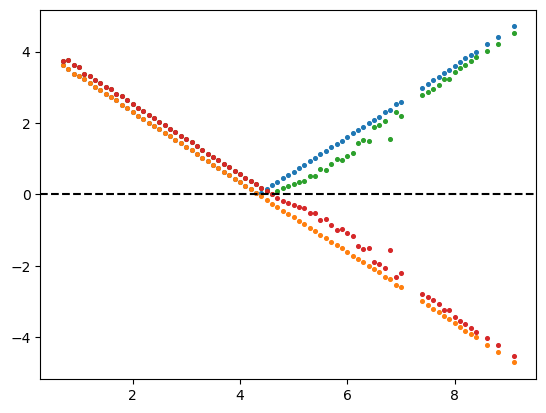

8


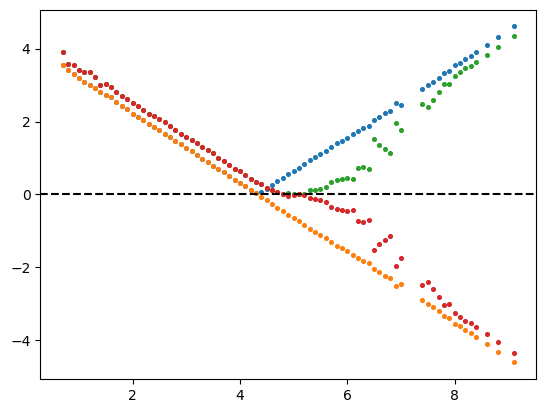

9


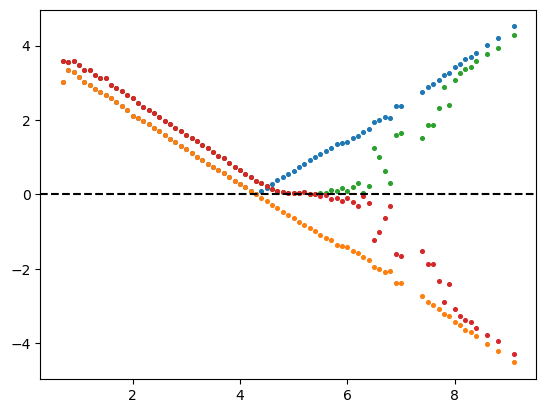

10


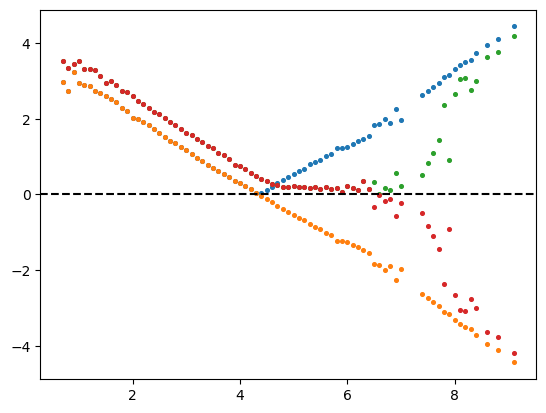

11


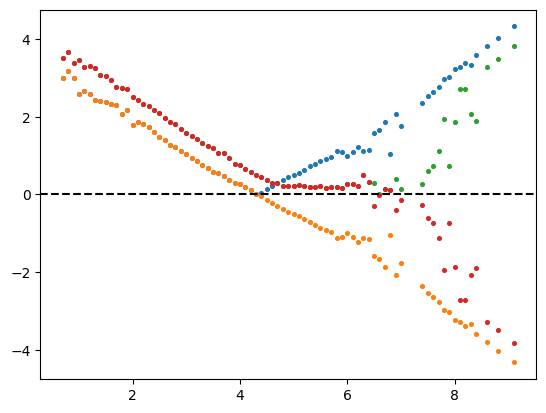

12


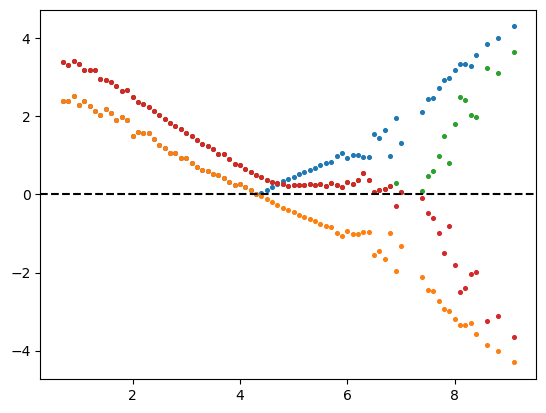

13


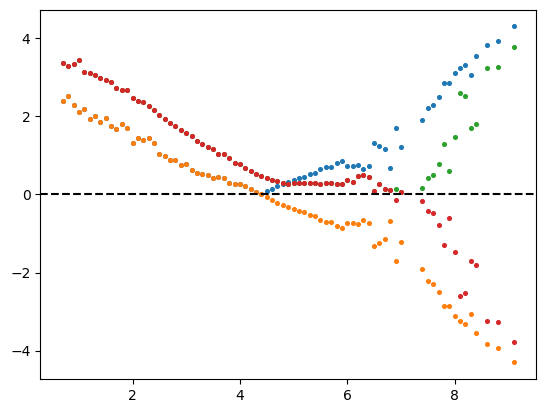

14


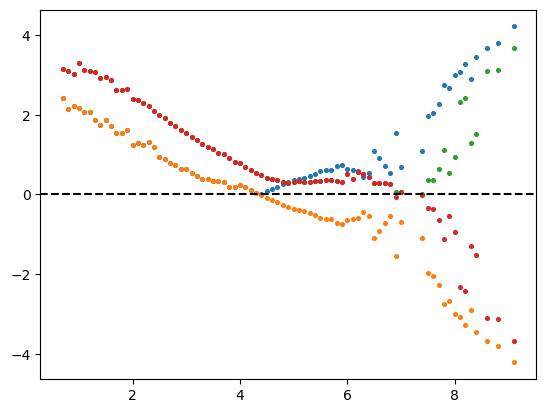

15


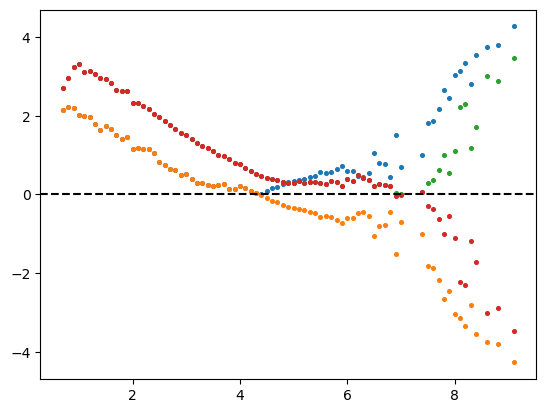

16


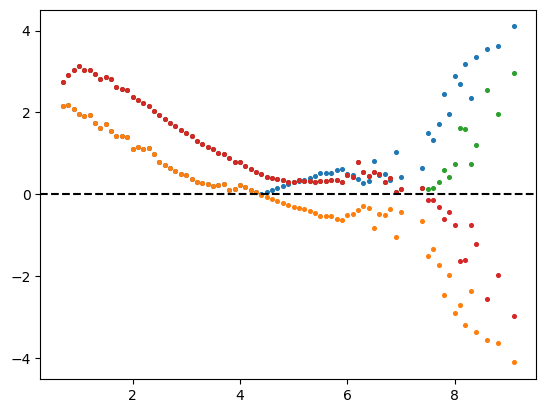

17


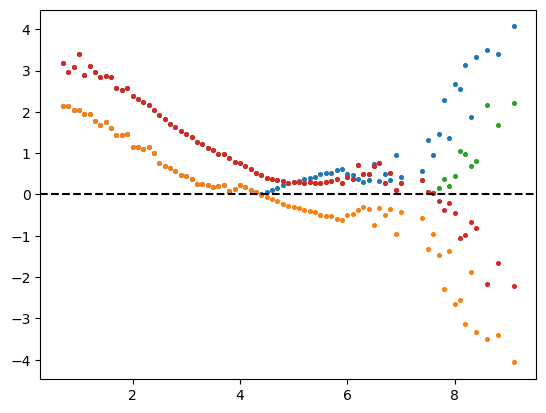

18


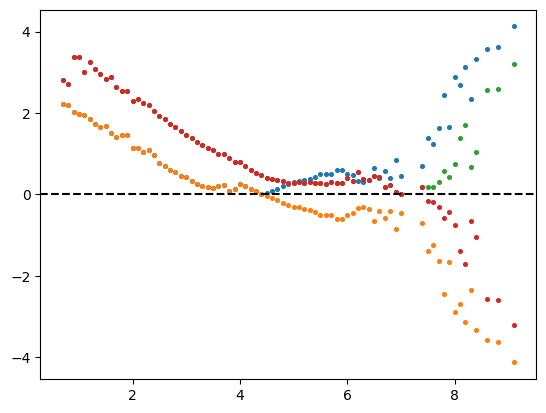

19


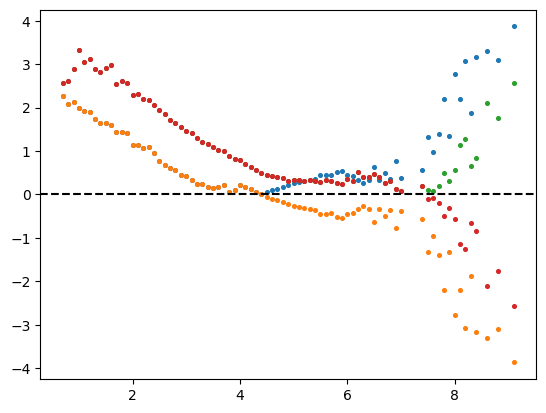

20


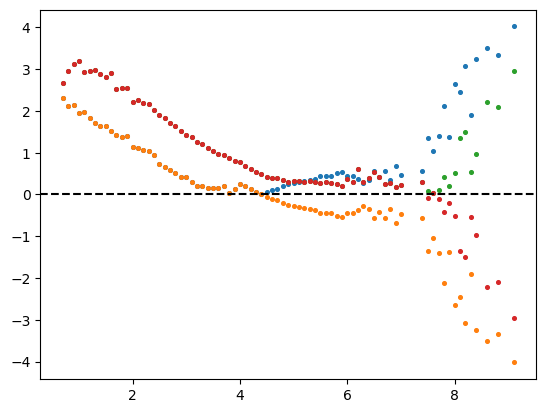

25


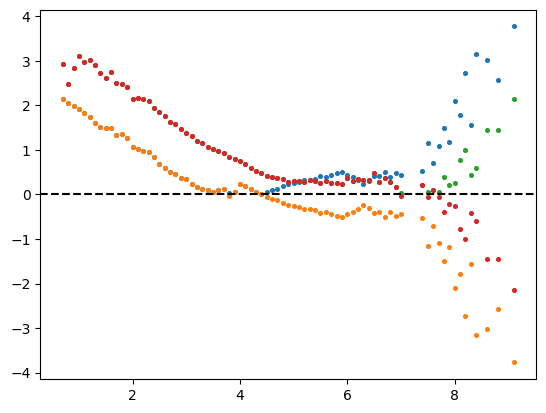

30


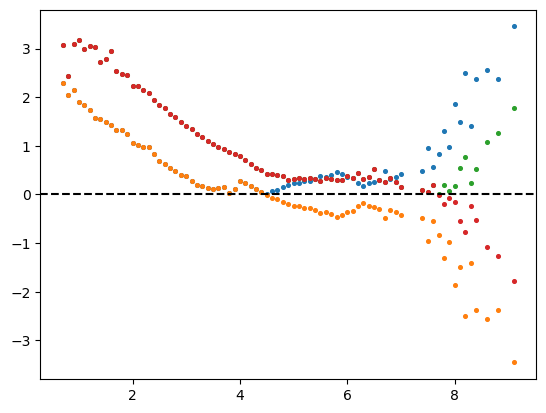

35


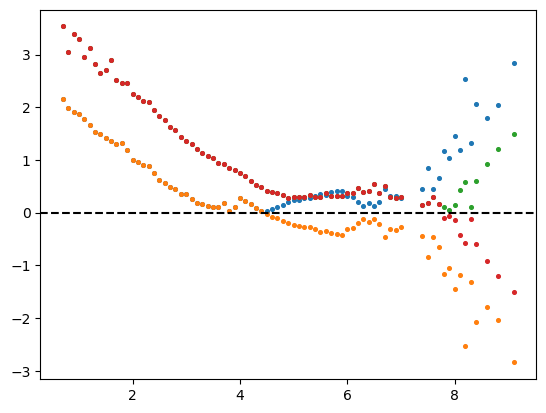

40


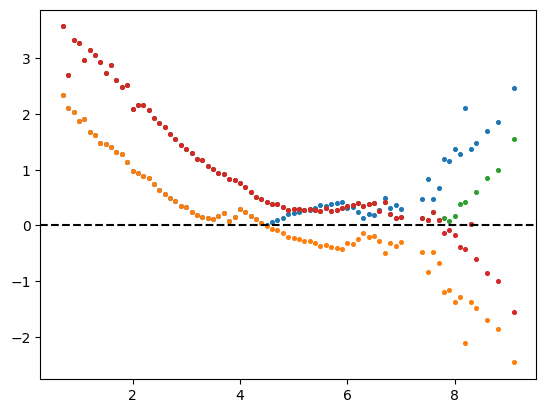

50


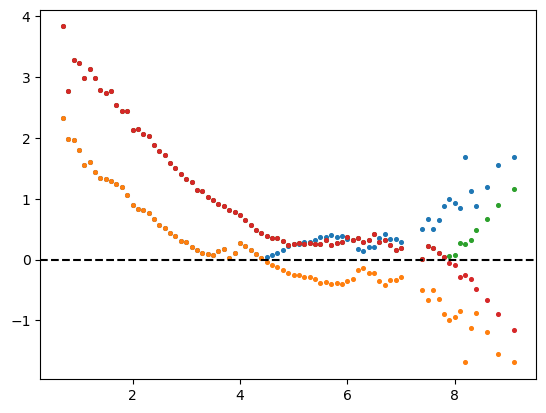

60


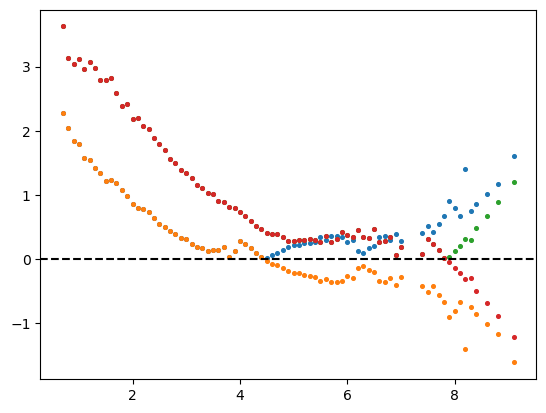

70


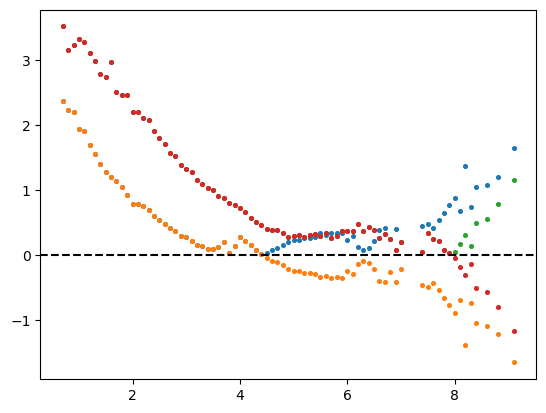

80


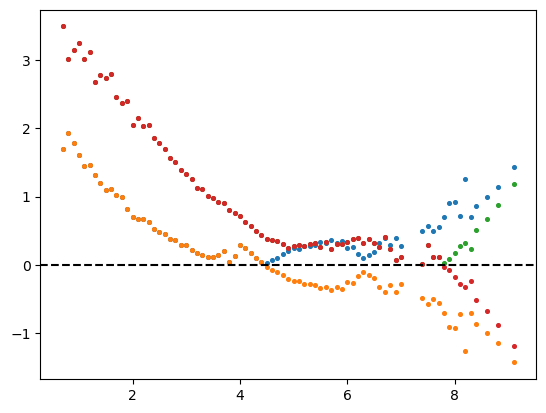

90


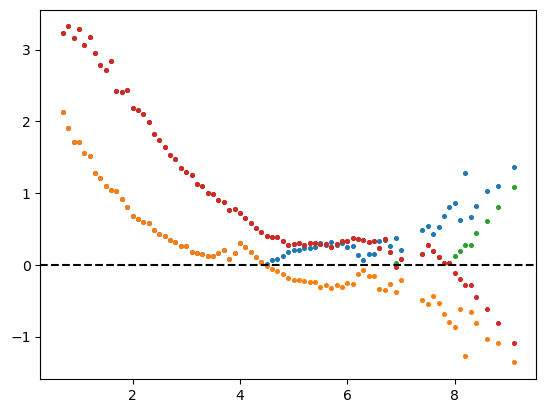

100


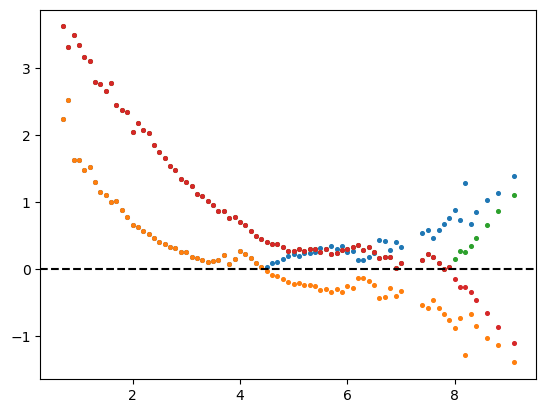

110


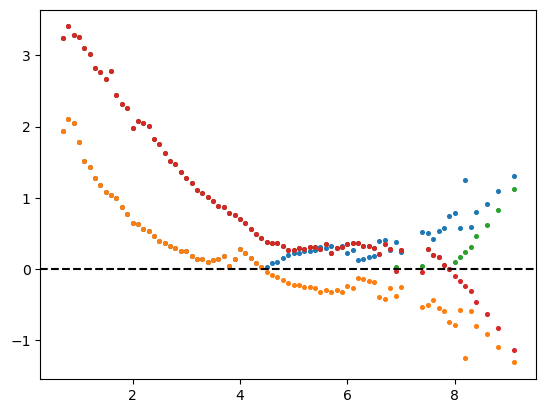

120


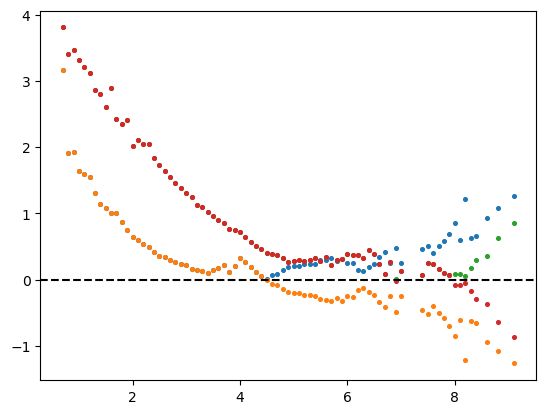

In [183]:
# from make_median_acc_data_forwill code - do same thing with 95th percentiles instead of medians

catmag_bins = bins

empty_for_will = np.zeros((26,85,5))
# print(empty_for_will)

for idx2 in range(len(cut_lens)):
#     print('---------------------------------')
#     print('Cut len: ' + str(cut_len))
#     print('Shift len: ' + str(cut_len-6))

    cut_len = cut_lens[idx2]
#     print(idx2)
    print(cut_len)
    
    stats_save_dir = '/home/sdybing/mlaapde/testdata_preds/all_test_rerun/revised_figures/boxplot_stats/' + str(cut_len-6) + 's_window/'
    
    medians = np.load(stats_save_dir + str(cut_len-6) + 's_window_medians.npy')
    per95s = np.load(stats_save_dir + str(cut_len-6) + 's_window_95thpercentile.npy')
    
    predmed_diff_from_catmag = []
    pred95_diff_from_catmag = []
    
    for idx in range(len(medians)):
        # print(idx)
        predmed = medians[idx]
        # print(predmed)
        catmag = catmag_bins[idx]
        # print(catmag)
        
        if predmed != np.nan:
            diff = predmed - catmag
            # print(diff)
        else:
            diff = np.nan
            
        predmed_diff_from_catmag.append(diff)
    
    for idx in range(len(per95s)):
        # print(idx)
        pred95 = per95s[idx]
        # print(predmed)
        catmag = catmag_bins[idx]
        # print(catmag)
        
        if pred95 != np.nan:
            diff = pred95 - catmag
            # print(diff)
        else:
            diff = np.nan
            
        pred95_diff_from_catmag.append(diff)
    
    abs_error_med = np.abs(predmed_diff_from_catmag)
    error_med = predmed_diff_from_catmag
    abs_error_95 = np.abs(pred95_diff_from_catmag)
    error_95 = pred95_diff_from_catmag
    
#     plt.scatter(catmag_bins, predmed_diff_from_catmag)
    plt.scatter(catmag_bins, abs_error_med, s = 7)
    plt.scatter(catmag_bins, error_med, s = 7)
    plt.scatter(catmag_bins, abs_error_95, s = 7)
    plt.scatter(catmag_bins, error_95, s = 7)
    plt.axhline(0, color = 'black', linestyle = '--')
    plt.show()
    
    empty_for_will[idx2, :, 0] = catmag_bins # catalog mags
    empty_for_will[idx2, :, 1] = error_med # error of median
    empty_for_will[idx2, :, 2] = abs_error_med # abs(error) of median
    empty_for_will[idx2, :, 3] = error_95 # error of 95th percentile
    empty_for_will[idx2, :, 4] = abs_error_95 # abs(error) of 95th percentile
    
# print(empty_for_will)

In [184]:
print(empty_for_will)

[[[ 0.7         3.62024002  3.62024002  3.74231772  3.74231772]
  [ 0.8         3.51899166  3.51899166  3.75374122  3.75374122]
  [ 0.9         3.38186083  3.38186083  3.62002182  3.62002182]
  ...
  [ 8.9                nan         nan         nan         nan]
  [ 9.                 nan         nan         nan         nan]
  [ 9.1        -4.70529423  4.70529423 -4.52656069  4.52656069]]

 [[ 0.7         3.55606918  3.55606918  3.90640502  3.90640502]
  [ 0.8         3.41986485  3.41986485  3.56563392  3.56563392]
  [ 0.9         3.29271564  3.29271564  3.54072285  3.54072285]
  ...
  [ 8.9                nan         nan         nan         nan]
  [ 9.                 nan         nan         nan         nan]
  [ 9.1        -4.60478172  4.60478172 -4.34309473  4.34309473]]

 [[ 0.7         3.01376038  3.01376038  3.58995097  3.58995097]
  [ 0.8         3.34925909  3.34925909  3.55779784  3.55779784]
  [ 0.9         3.27738962  3.27738962  3.59874096  3.59874096]
  ...
  [ 8.9           

In [185]:
np.save('/home/sdybing/mlaapde/testdata_preds/all_test_rerun/revised_figures/catmag_abserror_window.npy', empty_for_will)

In [186]:
# Heatmap figure for the median compared to 95th percentile

from scipy.interpolate import griddata

data = np.load('/home/sdybing/mlaapde/testdata_preds/all_test_rerun/revised_figures/catmag_abserror_window.npy')
times = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 19, 24, 29, 34, 44, 54, 64, 74, 84, 94, 104, 114]
mags = data[0,:,0]
error_med = data[:,:,1]
abs_error_med = data[:,:,2]
error_95 = data[:,:,3]
abs_error_95 = data[:,:,4]


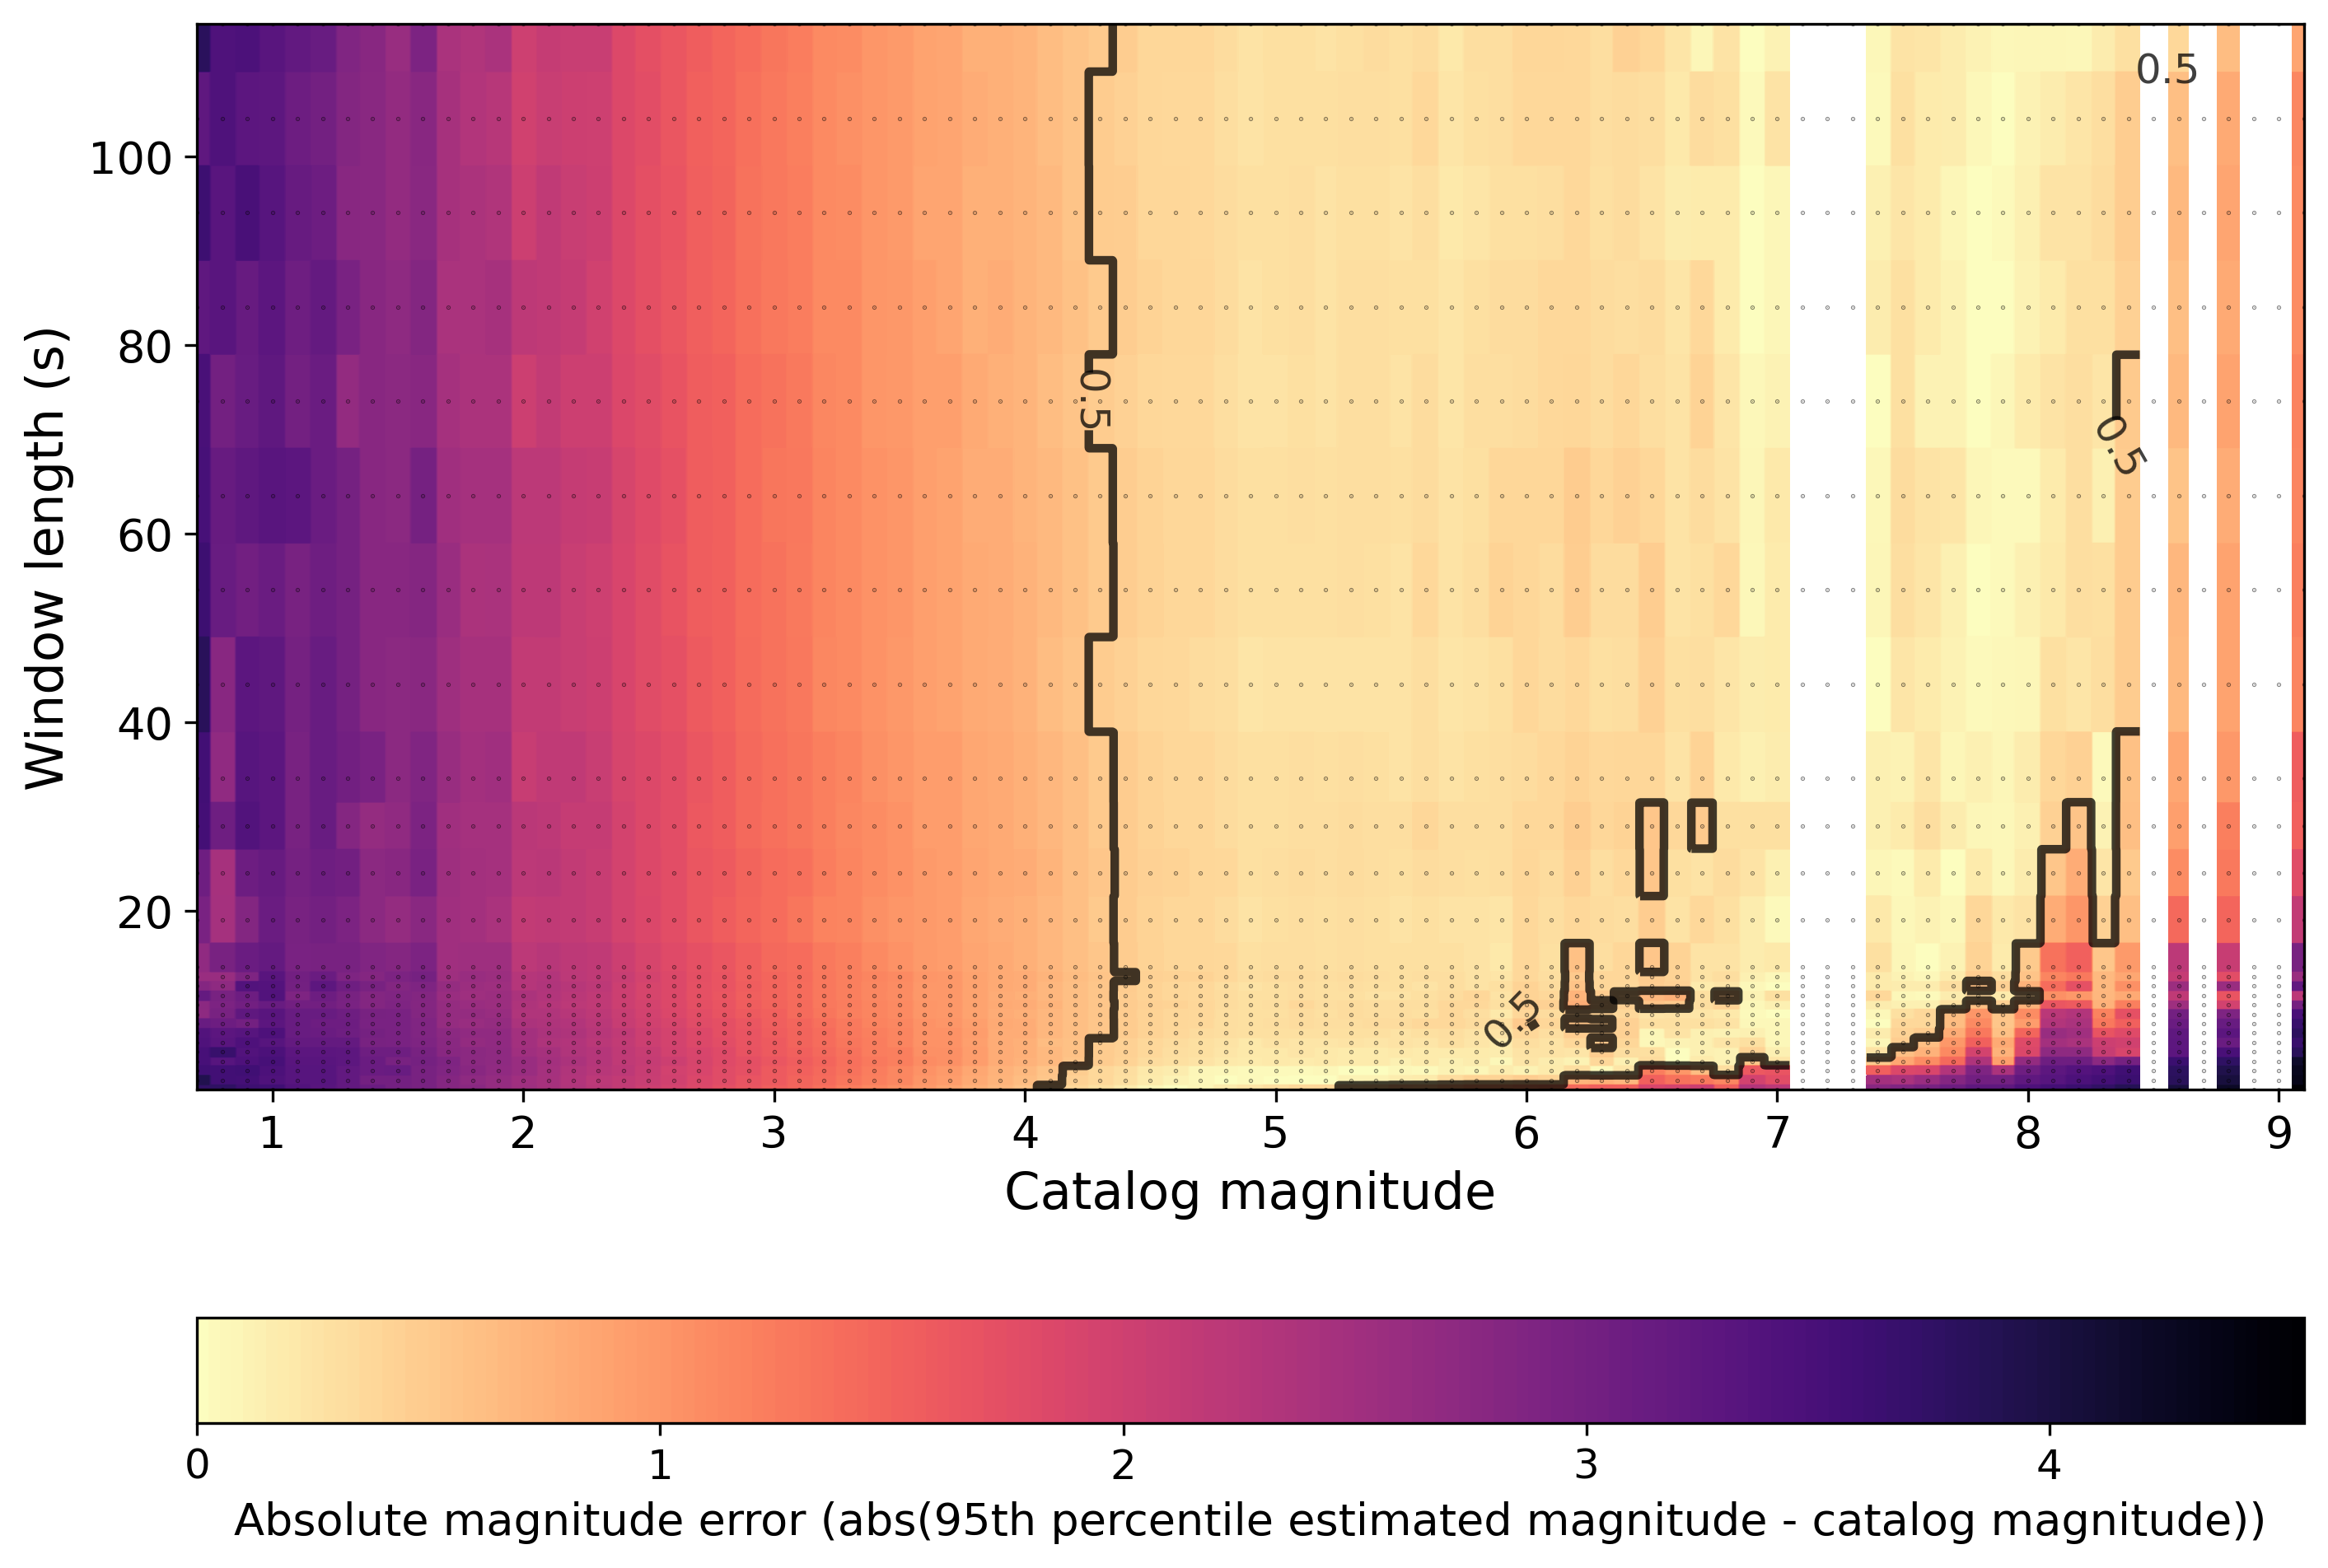

In [187]:
### ----- FIGURE 8 ----- ###

fig = plt.figure(figsize = (11, 8), dpi = 300)
ax = fig.add_subplot(111)

P = []
for xx in times:
    for yy in mags:
        P.append((yy, xx))

def fmt(x):
    s = f"{x:.1f}"
    if s.endswith("0"):
        s = f"{x:.0f}"
    return rf"{s}" if plt.rcParams["text.usetex"] else f"{s}"

y = np.linspace(1.0, 114.0, 1000)
x = np.linspace(0.7, 10, 1000)
X, Y = np.meshgrid(x, y)
Ti = griddata(P, abs_error_95.flatten(), (X, Y), method = 'nearest')
cb = ax.contourf(X, Y, Ti, cmap = 'magma_r', levels = 199)
cs = ax.contour(X, Y, Ti, origin = 'lower', levels = [0.5], colors = ['black'], linewidths = 2.5, alpha = 0.75)
manual_locations = [(2.5, 74), (5.5, 10), (7.65, 59), (7.6, 109)]
ax.clabel(cs, inline = True, fmt = fmt, manual = manual_locations, fontsize = 12)
xt, yt = zip(*P)
ax.plot(xt, yt, '.', color = 'black', alpha = 0.5, ms = 0.5)
ax.set_xlabel('Catalog magnitude', fontsize = 15)
ax.set_ylabel('Window length (s)', fontsize = 15)
ax.tick_params(axis = 'x', labelsize = 13)
ax.tick_params(axis = 'y', labelsize = 13)
cbar = fig.colorbar(cb, ticks = [-5, -4, -3, -2, -1, 0, 1, 2, 3, 4], orientation = 'horizontal')
cbar.ax.tick_params(labelsize = 12)
cbar.ax.set_xlabel(xlabel = 'Absolute magnitude error (abs(95th percentile estimated magnitude - catalog magnitude))', fontsize = 13)
ax.set_xlim(0.7, 9.1)
plt.show()
# plt.savefig('/home/sdybing/mlaapde/testdata_preds/all_test_rerun/revised_figures/95percentile_Fig8_errorheatmap.png', format = 'PNG')
# plt.close();


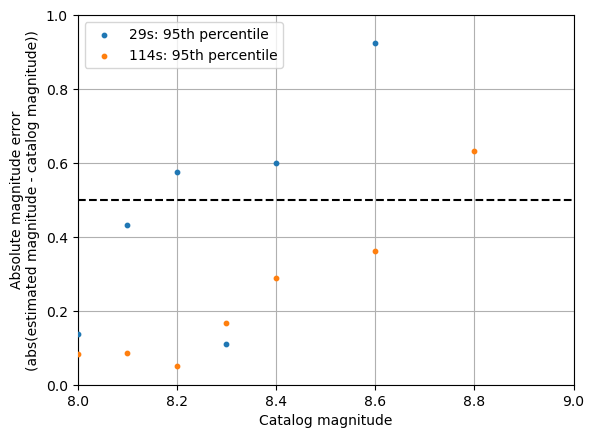

In [207]:
i = 16 # 29 second model

# plt.title('29 second model')
plt.axhline(0.5, color = 'black', linestyle = '--')
plt.grid(zorder = 1)
# plt.scatter(mags, error_med[i], zorder = 3, s = 10, label = 'Median (50th percentile)')
# plt.scatter(mags, error_95[i], zorder = 3, s = 10, label = '95th percentile')
# plt.scatter(mags, abs_error_med[i], zorder = 3, s = 10, label = '29s: Median (50th percentile)')
plt.scatter(mags, abs_error_95[i], zorder = 3, s = 10, label = '29s: 95th percentile')
# plt.scatter(mags, abs_error_med[-1], zorder = 3, s = 10, label = '114s: Median (50th percentile)')
plt.scatter(mags, abs_error_95[-1], zorder = 3, s = 10, label = '114s: 95th percentile')
plt.xlim(8,9)
plt.ylim(0,1)
plt.legend()
plt.xlabel('Catalog magnitude')
plt.ylabel('Absolute magnitude error\n(abs(estimated magnitude - catalog magnitude))')
plt.show();

# plt.ylim(0,1);
# for idx3 in range(len(cut_lens)):
#     plt.scatter(mags, error_95[idx3])

# plt.title('114 second model')
# plt.axhline(0.5, color = 'black', linestyle = '--')
# plt.grid(zorder = 1)
# # plt.scatter(mags, error_med[-1], zorder = 3, s = 10, label = 'Median (50th percentile)')
# # plt.scatter(mags, error_95[-1], zorder = 3, s = 10, label = '95th percentile')
# plt.scatter(mags, abs_error_med[-1], zorder = 3, s = 10, label = 'Median (50th percentile)')
# # plt.scatter(mags, abs_error_95[-1], zorder = 3, s = 10, label = '95th percentile')
# # plt.xlim(4,5)
# plt.legend()
# plt.xlabel('Catalog magnitude')
# plt.ylabel('Absolute magnitude error\n(abs(estimated magnitude - catalog magnitude))')

# plt.show()
# # plt.savefig('/home/sdybing/mlaapde/testdata_preds/all_test_rerun/revised_figures/95and50percentile_114smodel_errors.png', format = 'PNG')
# # plt.close();

# plt.ylim(0,1);
# for idx3 in range(len(cut_lens)):
#     plt.scatter(mags, error_95[idx3])

In [134]:
print(error_95[-1])

[3.80644779 3.41063161 3.46671886 3.31888151 3.20622597 3.12598486
 2.86730881 2.79866657 2.60097408 2.90019007 2.42237763 2.34770947
 2.40753503 2.01196289 2.10808437 2.05030894 2.0503973  1.83616998
 1.73620815 1.63823633 1.5522069  1.46343193 1.37773697 1.30866461
 1.24736052 1.12358205 1.09571166 1.01564813 0.95930433 0.892818
 0.85597982 0.75709677 0.75500998 0.71541872 0.64803286 0.57434392
 0.50635023 0.45515919 0.39892669 0.38076096 0.37604909 0.32520571
 0.27057238 0.27874405 0.29689889 0.2737237  0.29412479 0.32729068
 0.28563719 0.33494306 0.2245923  0.30299385 0.31575241 0.3824863
 0.37854733 0.36750593 0.32185185 0.44180007 0.37948203 0.22987261
 0.08989844 0.26331439 0.01366439 0.12349606        nan        nan
        nan 0.06687603 0.25477409 0.24303439 0.15831723 0.10332642
 0.06940308 0.084234   0.08648777 0.05008316 0.16799231 0.28970032
        nan 0.36125336        nan 0.63294082        nan        nan
 0.86118541]
